We sort by timestamp ascending because we need a monotonic time data for later use.

In [20]:
import py2neo
import pandas as pd

graph = py2neo.Graph()

query = """
MATCH
(t:Type)-->(ch:Change)<--(co:Commit)
RETURN t.fqn as type, co.date + " " + co.time as timestamp
ORDER BY timestamp
"""

changes = pd.DataFrame(graph.data(query))
changes.head()

,timestamp,type
0,2013-01-09 10:13:17 +0100,org.springframework.samples.petclinic.util.Ent...
1,2013-01-16 03:30:20 +0100,org.springframework.samples.petclinic.web.Owne...
2,2013-01-16 03:57:50 +0100,org.springframework.samples.petclinic.web.PetC...
3,2013-01-16 04:02:37 +0100,org.springframework.samples.petclinic.web.PetC...
4,2013-01-16 04:07:39 +0100,org.springframework.samples.petclinic.web.Visi...


In [21]:
changes.timestamp = pd.to_datetime(changes.timestamp)
changes_over_time = changes.set_index('timestamp')
changes_over_time.head()

,type
timestamp,
2013-01-09 09:13:17,org.springframework.samples.petclinic.util.Ent...
2013-01-16 02:30:20,org.springframework.samples.petclinic.web.Owne...
2013-01-16 02:57:50,org.springframework.samples.petclinic.web.PetC...
2013-01-16 03:02:37,org.springframework.samples.petclinic.web.PetC...
2013-01-16 03:07:39,org.springframework.samples.petclinic.web.Visi...


In [45]:
dependend_types_within_1hour = \
  changes_over_time.groupby('type').resample("1h").count()
dependend_types_within_1hour.head()

type
type                                               timestamp                
org.springframework.samples.petclinic.Petclinic... 2016-07-06 16:00:00     1
                                                   2016-07-06 17:00:00     0
                                                   2016-07-06 18:00:00     0
                                                   2016-07-06 19:00:00     0
                                                   2016-07-06 20:00:00     0

In [50]:
dependency_matrix = dependend_types_within_1hour.unstack().fillna(0)
dependency_matrix.iloc[:5,:3]

type  \
timestamp                                          2013-01-09 09:00:00   
type                                                                     
org.springframework.samples.petclinic.Petclinic...                 0.0   
org.springframework.samples.petclinic.model.Bas...                 0.0   
org.springframework.samples.petclinic.model.Nam...                 0.0   
org.springframework.samples.petclinic.model.Owner                  0.0   
org.springframework.samples.petclinic.model.Person                 0.0   

                                                                        \
timestamp                                          2013-01-09 10:00:00   
type                                                                     
org.springframework.samples.petclinic.Petclinic...                 0.0   
org.springframework.samples.petclinic.model.Bas...                 0.0   
org.springframework.samples.petclinic.model.Nam...                 0.0   
org.springframework.samples.petclinic.model.Owner                  0.0   
org.springframework.samples.petclinic.model.Person                 0.0   

                                                                        
timestamp                                          2013-01-09 11:00:00  
type                                                                    
org.springframework.samples.petclinic.Petclinic...                 0.0  
org.springframework.samples.petclinic.model.Bas...                 0.0  
org.springframework.samples.petclinic.model.Nam...                 0.0  
org.springframework.samples.petclinic.model.Owner                  0.0  
org.springframework.samples.petclinic.model.Person                 0.0

In [52]:
from sklearn.metrics.pairwise import cosine_distances

distance_matrix = cosine_distances(dependency_matrix)
distance_matrix[:5,:5]

array([[ 0.        ,  0.47973402,  1.        ,  1.        ,  1.        ],
       [ 0.47973402,  0.        ,  0.43804851,  0.54116853,  0.58960866],
       [ 1.        ,  0.43804851,  0.        ,  0.18350342,  0.26970326],
       [ 1.        ,  0.54116853,  0.18350342,  0.        ,  0.25464401],
       [ 1.        ,  0.58960866,  0.26970326,  0.25464401,  0.        ]])

In [53]:
distance_df = pd.DataFrame(
    distance_matrix,
    index=dependency_matrix.index,
    columns=dependency_matrix.index)
distance_df.iloc[:3,:3]

type,org.springframework.samples.petclinic.PetclinicInitializer,org.springframework.samples.petclinic.model.BaseEntity,org.springframework.samples.petclinic.model.NamedEntity
type,,,
org.springframework.samples.petclinic.PetclinicInitializer,0.000000,0.479734,1.000000
org.springframework.samples.petclinic.model.BaseEntity,0.479734,0.000000,0.438049
org.springframework.samples.petclinic.model.NamedEntity,1.000000,0.438049,0.000000


In [54]:
from sklearn.manifold import MDS

model = MDS(dissimilarity='precomputed')
T = model.fit_transform(distance_df)
T[:5]

array([[-0.13633063,  0.66974029],
       [-0.03844349,  0.18250675],
       [-0.0028786 , -0.33508867],
       [ 0.02943364, -0.31556507],
       [-0.15292003, -0.4830353 ]])

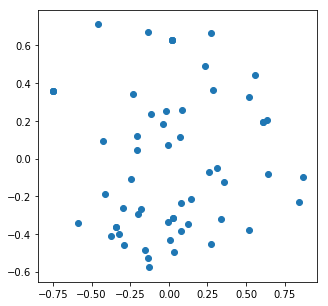

In [61]:
plt.figure(figsize=(5,5))
plt.scatter(T[:,0], T[:,1])

In [84]:
T_df = pd.DataFrame(T, columns=['x','y'])
T_df['class'] = distance_df.index
T_df.head()

,x,y,class
0,-0.136331,0.669740,org.springframework.samples.petclinic.Petclini...
1,-0.038443,0.182507,org.springframework.samples.petclinic.model.Ba...
2,-0.002879,-0.335089,org.springframework.samples.petclinic.model.Na...
3,0.029434,-0.315565,org.springframework.samples.petclinic.model.Owner
4,-0.152920,-0.483035,org.springframework.samples.petclinic.model.Pe...


In [85]:
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool

def scatter_with_hover(df, x, y,fig_width=500, fig_height=500):
   
    fig = figure(width=fig_width, height=fig_height)
    source = ColumnDataSource(data=df)
    name = 'main'
    fig.scatter(x, y, source=source, name='main')
    hover = HoverTool(names=[name])
    hover.tooltips = [(c, '@' + c) for c in df.columns]
    hover.tooltips.append(('index', '$index'))
    fig.add_tools(hover)
    return fig


In [88]:
from bokeh.plotting import output_notebook, show

fig = scatter_with_hover(T_df,"x","y")
output_notebook()
show(fig)

Loading BokehJS ...

In [58]:
%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt

types = distance_df.index / distance_df.index.max()
colors = [x for x in cm.hsv(types)]

plt.figure(figsize=(5,5))
plt.scatter(T[:,0], T[:,1], c=colors)

TypeError: cannot perform __truediv__ with this index type: <class 'pandas.core.indexes.base.Index'>